In [22]:
# -*- coding:UTF-8 -*-
# This is the simulation of our evolving RS model under the FIRST framework of our assumptions on edge weights.
import math
import numpy as np
# import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import norm
import config
import powerlaw

In [23]:
#Initial settings of parameters in our weighted bipartite graph model B(U,I).
beta = config.beta # the probability to add a new vertex in U
iterations = config.iterations # the number of iterations to run the simulation
rating_scale = config.rating_scale # the preassigned rating scale
Cu = config.Cu # the least number of edges connected to vertices in U
Ci = config.Ci # the least number of edges connected to vertices in I
Unum = config.Unum # the number of vertices in U in the initial graph at t=0
Inum = config.Inum # the number of vertices in I in the initial graph at t=1
K = config.K # the number of basic user type in our assumption
L = config.L # the number of basic item level in our assumption
Huser = np.zeros((K,rating_scale)) # the rating pmf for the K user types
Hitem = np.zeros((L,rating_scale)) # the rating pmf for the L item levels
Fmean = np.zeros((K,)) # the mean of the distribution of users' weight vector (assumed to be Gaussian)
Gmean = np.zeros((L,)) # the mean of the distribution of items' weight vector (assumed to be Gaussian)
edges = np.zeros((iterations+50,iterations+50), dtype=int) # the matrix storing edge information

In [24]:

# Initalization of the sampling of edge weights from the mixture distribution
def init_weightgenerator():
    global K,L,Huser,Hitem,rating_scale,Fmean,Gmean
    Huser = np.random.sample((K,rating_scale))
    Husersubsum = np.sum(Huser,axis=1)
    Husersubsum = np.array([Husersubsum]*rating_scale)
    Husersubsum = np.transpose(Husersubsum)
    Huser = Huser/Husersubsum
    Hitem = np.random.sample((L,rating_scale))
    Hitemsubsum = np.sum(Hitem,axis=1)
    Hitemsubsum = np.array([Hitemsubsum]*rating_scale)
    Hitemsubsum = np.transpose(Hitemsubsum)
    Hitem = Hitem/Hitemsubsum
    Fmean = np.random.sample(K,)
    Fmean = Fmean/np.sum(Fmean)
    Gmean = np.random.sample(L,)
    Gmean = Gmean/np.sum(Gmean)

# Sample edge weight(s) for new users in U from the mixture distribution
def userweightgenerator(nb):
    global K,L,Huser,Hitem,rating_scale,Fmean,Gmean
    Uvec = np.random.normal(Fmean,0.1)
    Uvec[Uvec<0]=0
    Uvec = Uvec/np.sum(Uvec)
    Uvec = np.array([Uvec]*rating_scale)
    Uvec = np.transpose(Uvec)
    Hu = Huser*Uvec
    Hu = np.sum(Hu,axis=0)
    R = np.random.choice(rating_scale,nb,p=Hu)+1
    return R

# Sample edge weight(s) for new items in I from the mixture distribution
def itemweightgenerator(nb):
    global K,L,Huser,Hitem,rating_scale,Fmean,Gmean
    Ivec = np.random.normal(Gmean,0.1)
    Ivec[Ivec<0]=0
    Ivec = Ivec/np.sum(Ivec)
    Ivec = np.array([Ivec]*rating_scale)
    Ivec = np.transpose(Ivec)
    Hi = Hitem*Ivec
    Hi = np.sum(Hi,axis=0)
    R = np.random.choice(rating_scale,nb,p=Hi)+1
    return R

# Initialization for the inital simple graph at t=0
def init():
    print ('Initalizing...')
    global edges,Unum,Inum
    init_weightgenerator()
    edges = np.zeros((iterations+50,iterations+50), dtype=int)
    for i in range(Unum):
        edges[i,0:Inum] = userweightgenerator(Inum)
    print ('Done.')
    
# Select "prototype" from the existing vertex group
def prototype(arr, nb):
    return np.count_nonzero(arr.cumsum() < nb)

# Conduct Edge-copy and assign new edge weights
def copyedge(template, desired,p_prime):
    ls = []
    new2old = template.nonzero()[0]
    tmp = template[new2old].astype(float)
    for i in range(desired):
        tmp /= tmp.sum()
        sampled = np.nonzero(np.random.multinomial(1, tmp))[0][0]
        ls.append(sampled)
        tmp[sampled] = 0
    ls.sort()
    return new2old[ls]

# Add new vertices to U (respectively. I)
def addnode(nb_axis):
    global edges,Unum,Inum
    weightsum = np.sum(edges[:Unum,:Inum], axis=nb_axis)
    totalsum = np.sum(weightsum)
    randnum = np.random.randint(1, totalsum+1)
    p_prime = prototype(weightsum, randnum)
    weighted = np.zeros(1)
    if nb_axis == 1:
        template = edges[p_prime, :Inum]
        desired = Cu
        weighted = userweightgenerator(template.shape[0])
    else:
        template = edges[:Unum, p_prime]
        desired = Ci
        weighted = itemweightgenerator(template.shape[0])
    idx = copyedge(template, desired,p_prime)
    new = np.zeros(template.shape[0],dtype=int)
    new[idx] = weighted[idx]
    if nb_axis == 1:
        edges[Unum,:Inum] = new
        Unum = Unum + 1
        # print(list(new), file=f)
    else:
        edges[:Unum,Inum] = new
        Inum = Inum + 1
        # print(list(new), file=f)

# Evolution of U (or I)
def evolution():
    randnum = np.random.rand()
    if randnum < beta:
        addnode(1)
    else:
        addnode(0)
    
# Gather statistic information
def stat():
    global edges
    tmps = edges.flatten().astype(int)
    count = np.bincount(tmps)
    count = count[1:]
    count = 1.0*count/count.sum()
    # print("stat", count)
    return count
    
# Calculate degree distributions
def calcdegree_U():
    global edges
    # print("calcdegree", edges)
    sumdegree = edges.astype(bool).sum(axis=0)
    return np.bincount(sumdegree)

# Calculate vertex weight distributions
def calcweight_U():
    global edges
    sumdegree = edges.sum(axis=0)
    return np.bincount(sumdegree)

def calcdegree_I():
    global edges
    # print("calcdegree", edges)
    sumdegree = edges.astype(bool).sum(axis=1)
    return np.bincount(sumdegree)

# Calculate vertex weight distributions
def calcweight_I():
    global edges
    sumdegree = edges.sum(axis=1)
    return np.bincount(sumdegree)

def DataFit(X, Y, year):
    # 模型数据准备
    X_parameter=[]
    Y_parameter=[]
    for single_square_feet ,single_price_value in zip(X,Y):
        X_parameter.append([float(single_square_feet)])
        Y_parameter.append(float(single_price_value))

    # 模型拟合
    regr = linear_model.LinearRegression()
    regr.fit(X_parameter, Y_parameter)

    #加p_value
    try:
        data = Y
        # print(data)
        results = powerlaw.Fit(data)
        alpha = results.power_law.alpha
        xmin = results.power_law.xmin
        R, p_value = results.distribution_compare('power_law', 'lognormal')
        print("p_value:", p_value, "item alpha:", alpha, "item xmin:", xmin)
    except:
        pass

    # 模型结果与得分
    # print("#", year, ":")
    # print("幂律指数𝜑: \n", 0-regr.coef_[0])
    # print("Intercept:\n",regr.intercept_)
    # The mean square error
    # print("rest: %.8f" % np.mean((regr.predict(X_parameter) - Y_parameter) ** 2))  # 残差平方和

    phi = 0-regr.coef_[0]
    return phi, year#, p_value, alpha

def main():
    I_x = np.zeros(rating_scale)
    I_deg = np.zeros(iterations+1)
    I_wei = np.zeros(iterations+1)
    
    I_w_y = []
    I_w_phi = []

    I_d_y = []
    I_d_phi = []

    U_x = np.zeros(rating_scale)
    U_deg = np.zeros(iterations+1)
    U_wei = np.zeros(iterations+1)
    
    U_w_y = []
    U_w_phi = []

    U_d_y = []
    U_d_phi = []

    for i in range(1):
        init()
        k = stat()
        #Begin iteration...
        for i in range(iterations):
            evolution()
            if i % 100 == 0 and i != 0:
                U_res = stat()
                U_deg = calcdegree_U()
                U_weights = calcweight_U()
                U_k = (U_res, U_deg, U_weights)

                U_x[:U_k[0].size] = U_x[:U_k[0].size] + U_k[0]
                U_deg[:min(i+1,U_k[1].size)] = U_deg[:min(i+1,U_k[1].size)] + U_k[1][:min(i+1,U_k[1].size)]
                U_wei[:min(i+1,U_k[2].size)] = U_wei[:min(i+1,U_k[2].size)] + U_k[2][:min(i+1,U_k[2].size)]

                I_res = stat()
                I_deg = calcdegree_I()
                I_weights = calcweight_I()
                I_k = (I_res, I_deg, I_weights)

                I_x[:I_k[0].size] = I_x[:I_k[0].size] + I_k[0]
                I_deg[:min(i+1,I_k[1].size)] = I_deg[:min(i+1,I_k[1].size)] + I_k[1][:min(i+1,I_k[1].size)]
                I_wei[:min(i+1,I_k[2].size)] = I_wei[:min(i+1,I_k[2].size)] + I_k[2][:min(i+1,I_k[2].size)]

                U_xind = np.zeros(i+1)
                for ii in range(1,i+1):
                    U_xind[ii]=U_xind[ii-1]+1

                I_xind = np.zeros(i+1)
                for ii in range(1,i+1):
                    I_xind[ii]=I_xind[ii-1]+1

                U_X_wei = []
                U_Y_wei = []
                for ii in range(1, len(U_wei[1:])+1):#len(wei[1:])+1
                    if U_wei[ii]>0:
                        U_X_wei.append(math.log10(U_xind[ii]))
                        U_Y_wei.append(math.log10(U_wei[ii]))
                U_phi_wei, U_year_wei = DataFit(U_X_wei, U_Y_wei, i)
                U_w_y.append(U_year_wei)
                U_w_phi.append(U_phi_wei)

                I_X_wei = []
                I_Y_wei = []
                for ii in range(1, len(I_wei[1:])+1):#len(wei[1:])+1
                    if I_wei[ii]>0:
                        I_X_wei.append(math.log10(I_xind[ii]))
                        I_Y_wei.append(math.log10(I_wei[ii]))
                I_phi_wei, I_year_wei = DataFit(I_X_wei, I_Y_wei, i)
                I_w_y.append(I_year_wei)
                I_w_phi.append(I_phi_wei)                

                U_X_deg = []
                U_Y_deg = []
                for ii in range(1, len(U_deg[1:])+1):#len(wei[1:])+1
                    if U_deg[ii]>0:
                        U_X_deg.append(math.log10(U_xind[ii]))
                        U_Y_deg.append(math.log10(U_deg[ii]))
                U_phi_deg, U_year_deg = DataFit(U_X_deg, U_Y_deg, i)
                U_d_y.append(U_year_deg)
                U_d_phi.append(U_phi_deg)

                I_X_deg = []
                I_Y_deg = []
                for ii in range(1, len(I_deg[1:])+1):#len(wei[1:])+1
                    if I_deg[ii]>0:
                        I_X_deg.append(math.log10(I_xind[ii]))
                        I_Y_deg.append(math.log10(I_deg[ii]))
                I_phi_deg, I_year_deg = DataFit(I_X_deg, I_Y_deg, i)
                I_d_y.append(I_year_deg)
                I_d_phi.append(I_phi_deg)

        U_res = stat()
        U_deg = calcdegree_U()
        U_weights = calcweight_U()
        U_k = (U_res, U_deg, U_weights)

        U_x[:U_k[0].size] = U_x[:U_k[0].size] + U_k[0]
        U_deg[:min(iterations+1,U_k[1].size)] = U_deg[:min(iterations+1,U_k[1].size)] + U_k[1][:min(iterations+1,U_k[1].size)]
        U_wei[:min(iterations+1,U_k[2].size)] = U_wei[:min(iterations+1,U_k[2].size)] + U_k[2][:min(iterations+1,U_k[2].size)]

        I_res = stat()
        I_deg = calcdegree_I()
        I_weights = calcweight_I()
        I_k = (I_res, I_deg, I_weights)

        I_x[:I_k[0].size] = I_x[:I_k[0].size] + I_k[0]
        I_deg[:min(iterations+1,I_k[1].size)] = I_deg[:min(iterations+1,I_k[1].size)] + I_k[1][:min(iterations+1,I_k[1].size)]
        I_wei[:min(iterations+1,I_k[2].size)] = I_wei[:min(iterations+1,I_k[2].size)] + I_k[2][:min(iterations+1,I_k[2].size)]
    
    U_xind = np.zeros(iterations+1)
    for i in range(1,iterations+1):
        U_xind[i]=U_xind[i-1]+1

    I_xind = np.zeros(iterations+1)
    for i in range(1,iterations+1):
        I_xind[i]=I_xind[i-1]+1

    U_X_wei = []
    U_Y_wei = []
    U_weight_sum = 0.0
    U_pos=0
    for i in range(1, len(U_wei[1:])+1):
        if U_wei[i]>0:
            U_pos+=1
            U_weight_sum+=math.log10(U_wei[i])
            U_X_wei.append(math.log10(U_xind[i]))
            U_Y_wei.append(math.log10(U_wei[i]))
    U_Er = U_weight_sum/U_pos 
    U_big_c = U_Er*(1+Cu*beta/(Ci*(1-beta)))
    print("USER C:", U_big_c)
    print("USER theoritical alpha upper bounds:", (U_big_c+1)/rating_scale)
    print("USER theoritical alpha lower bounds:", (U_big_c+rating_scale))
    U_u_b = (U_big_c+1)/rating_scale
    U_l_b = U_big_c+rating_scale

    U_phi_wei, U_year_wei = DataFit(U_X_wei,U_Y_wei,iterations)
    U_w_y.append(U_year_wei)
    U_w_phi.append(U_phi_wei)

    I_X_wei = []
    I_Y_wei = []
    I_weight_sum = 0.0
    I_pos=0
    for i in range(1, len(I_wei[1:])+1):
        if I_wei[i]>0:
            I_pos+=1
            I_weight_sum+=math.log10(I_wei[i])
            I_X_wei.append(math.log10(I_xind[i]))
            I_Y_wei.append(math.log10(I_wei[i]))
    I_Er = I_weight_sum/I_pos 
    I_big_c = I_Er*(1+Ci*(1-beta)/(Cu*beta))
    print("ITEM C:", I_big_c)
    print("ITEM theoritical alpha upper bounds:", (I_big_c+1)/rating_scale)
    print("ITEM theoritical alpha lower bounds:", (I_big_c+rating_scale))
    I_u_b = (I_big_c+1)/rating_scale
    I_l_b = I_big_c+rating_scale

    U_phi_wei, U_year_wei = DataFit(U_X_wei,U_Y_wei,iterations)
    U_w_y.append(U_year_wei)
    U_w_phi.append(U_phi_wei)

    I_phi_wei, I_year_wei = DataFit(I_X_wei,I_Y_wei,iterations)
    I_w_y.append(I_year_wei)
    I_w_phi.append(I_phi_wei)

    U_X_deg = []
    U_Y_deg = []
    for i in range(1, len(U_deg[1:])+1):
        if U_deg[i]>0:
            U_X_deg.append(math.log10(U_xind[i]))
            U_Y_deg.append(math.log10(U_deg[i]))
    U_phi_deg, U_year_deg = DataFit(U_X_deg,U_Y_deg,iterations)
    U_d_y.append(U_year_deg)
    U_d_phi.append(U_phi_deg)

    I_X_deg = []
    I_Y_deg = []
    for i in range(1, len(I_deg[1:])+1):
        if I_deg[i]>0:
            I_X_deg.append(math.log10(I_xind[i]))
            I_Y_deg.append(math.log10(I_deg[i]))
    I_phi_deg, I_year_deg = DataFit(I_X_deg,I_Y_deg,iterations)
    I_d_y.append(I_year_deg)
    I_d_phi.append(I_phi_deg)

    # print(len(d_y), len(d_phi))
    # print(len(w_y), len(w_phi))
    # print(d_y)
    # print(w_y)
    # print("w_phi:", w_phi)
    print("USER d_phi:", U_d_phi)
    print("ITEM d_phi:", I_d_phi)
    # plt.figure(figsize=(1,2),dpi=80)
    # ax1 = plt.subplot(121)
    # plt.plot(w_y,w_phi,'bo')
    # plt.plot(U_d_y,U_d_phi,'r+')
    # plt.hlines(U_u_b, 0, max(U_d_y), colors ="r", linestyles = "dashed")
    # plt.hlines(U_l_b, 0, max(U_d_y), colors ="r", linestyles = "dashed")
    # plt.plot(I_d_y,I_d_phi,'bo')
    # plt.hlines(I_u_b, 0, max(I_d_y), colors ="b", linestyles = "dashed")
    # plt.hlines(I_l_b, 0, max(I_d_y), colors ="b", linestyles = "dashed")
    # plt.title('degree\'s phi evolving graph, beta=' + str(beta))
    # plt.xlabel('iteration time')
    # plt.ylabel('phi')
    # plt.show()
    # plt.savefig('./degree_phi_evol_graph.png')
    # ax2 = plt.subplot(122)
    
    
    plt.plot(U_w_y,U_w_phi,'o', c='black')
    plt.hlines(U_u_b, 0, max(U_w_y), colors ="black", linestyles = "dashed")
    plt.hlines(U_l_b, 0, max(U_w_y), colors ="black", linestyles = "dashed")
    # plt.title('weight\'s phi evolving graph, beta=' + str(beta))
    plt.xlabel('Iteration Time')
    plt.ylabel(r'$\alpha $')
    
    plt.savefig(r'User Weight evolving graph.png')
    plt.show()
    plt.cla()
    plt.plot(I_w_y,I_w_phi,'o', c='grey')
    plt.hlines(I_u_b, 0, max(I_w_y), colors ="grey", linestyles = "dashed")
    plt.hlines(I_l_b, 0, max(I_w_y), colors ="grey", linestyles = "dashed")
    # plt.title('weight\'s phi evolving graph, beta=' + str(beta))
    plt.xlabel('Iteration Time')
    plt.ylabel(r'$\alpha $')
    plt.savefig(r'item Weight evolving graph.png')
    plt.showw()

Initalizing...
Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:139: RuntimeWarning: invalid value encountered in greater_equal
  self.data = self.data[self.data>=self.xmin]
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1141: RuntimeWarning: invalid value encountered in double_scalars
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1160: RuntimeWarning: invalid value encountered in double_scalars
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
/home/daven/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/daven/.local/lib/python3.6/site-packages/numpy/core/_

p_value: 1 item alpha: nan item xmin: nan
p_value: 7.293293525721294e-13 item alpha: 6.51681474937051 item xmin: 0.3010299956639812
p_value: 0.19104431621748552 item alpha: 10.859088502395123 item xmin: 0.6020599913279624
p_value: 0.7165753528136443 item alpha: 6.869838725532118 item xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 0.24922022639958374 item alpha: 11.636247946292174 item xmin: 0.3010299956639812
p_value: 0.994755182384006 item alpha: 16.00218535213693 item xmin: 0.9542425094393249
p_value: 0.052470757228691316 item alpha: 16.288789365198003 item xmin: 0.7781512503836436
p_value: 0.7564331985780843 item alpha: 3.928453070824072 item xmin: 0.7781512503836436


/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit

p_value: 0.002567209152817711 item alpha: 15.334090790512418 item xmin: 0.6020599913279624
p_value: 0.24172951802706877 item alpha: 5.187340211282304 item xmin: 0.8450980400142568
p_value: 0.12951544392979128 item alpha: 7.29024775958306 item xmin: 0.6020599913279624
p_value: 0.6058740044431801 item alpha: 5.364868263700682 item xmin: 1.2041199826559248


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 2.628581546990232e-73 item alpha: 12.116784153940282 item xmin: 0.6989700043360189
p_value: 0.040775777110621664 item alpha: 3.0596884332359613 item xmin: 0.6020599913279624
p_value: 0.0614224961990021 item alpha: 12.261803346515318 item xmin: 0.9030899869919435
p_value: 0.7622443478599715 item alpha: 3.114749507635134 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 0.02331624169576577 item alpha: 31.013115898553217 item xmin: 0.9030899869919435
p_value: 0.07678740567814007 item alpha: 2.968650099552626 item xmin: 0.6020599913279624
p_value: 0.06950102435850425 item alpha: 6.835193829973716 item xmin: 0.7781512503836436
p_value: 0.7779914685680174 item alpha: 6.335143056543361 item xmin: 1.414973347970818


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overfl

p_value: 0.7455633064781513 item alpha: 5.478695931180022 item xmin: 0.6020599913279624
p_value: 0.03628522424433523 item alpha: 3.2757513333261747 item xmin: 0.7781512503836436
p_value: 0.12587413098110942 item alpha: 23.149958662324035 item xmin: 1.0791812460476249
p_value: 0.7477469897220319 item alpha: 2.9835208339582278 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 0.0013046925925438973 item alpha: 9.552530830701809 item xmin: 0.8450980400142568
p_value: 0.022954545935606908 item alpha: 3.4852885872598467 item xmin: 0.9030899869919435
p_value: 0.836914396381005 item alpha: 13.616115853683013 item xmin: 1.0791812460476249
p_value: 0.42244332938347073 item alpha: 2.7170689620269 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.6346083191313141 item alpha: 9.188859660929445 item xmin: 0.9030899869919435
p_value: 0.028113673423384028 item alpha: 3.620452325943822 item xmin: 1.0
p_value: 0.9847272787083153 item alpha: 13.841211867691175 item xmin: 1.2041199826559248
p_value: 0.321629369042599 item alpha: 3.0204962728556235 item xmin: 0.7781512503836436


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.8813030476627564 item alpha: 10.545105294866115 item xmin: 1.0
p_value: 0.03143508033040773 item alpha: 3.2708695574103004 item xmin: 0.9030899869919435
p_value: 0.814800570990743 item alpha: 8.409059562314312 item xmin: 1.146128035678238
p_value: 0.376985812291444 item alpha: 3.041398440015536 item xmin: 0.7781512503836436


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.6419361626145729 item alpha: 10.201161712938267 item xmin: 1.0791812460476249
p_value: 0.010973648958225344 item alpha: 3.1416712153253568 item xmin: 0.9030899869919435
p_value: 0.7784236253334733 item alpha: 5.802533711670303 item xmin: 0.9030899869919435
p_value: 0.2155130474868061 item alpha: 2.889828290085255 item xmin: 0.7781512503836436


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.210232952939163 item alpha: 8.847292588464748 item xmin: 1.1139433523068367
p_value: 0.007780484806528366 item alpha: 3.3715414874076868 item xmin: 1.041392685158225
p_value: 0.7757367518979215 item alpha: 14.807879239879808 item xmin: 1.3010299956639813
p_value: 0.40501821266525895 item alpha: 2.6958499635648443 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.15346484513048644 item alpha: 8.59201336354915 item xmin: 1.146128035678238
p_value: 0.6341008107987833 item alpha: 36.91168386063175 item xmin: 2.278753600952829
p_value: 0.718396259154378 item alpha: 4.689434336834763 item xmin: 0.7781512503836436
p_value: 0.24648284876796334 item alpha: 3.3374335147510608 item xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.07936906297648377 item alpha: 8.92175786863234 item xmin: 1.2304489213782739
p_value: 0.5083369705387264 item alpha: 35.07387353439376 item xmin: 2.346352974450639
p_value: 0.3744939241879004 item alpha: 4.8703307483853004 item xmin: 0.9030899869919435
p_value: 0.40561024830955006 item alpha: 2.637790541844584 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 1.0770414613733938e-31 item alpha: 44.85879212731999 item xmin: 1.568201724066995
p_value: 0.0027860542644521464 item alpha: 2.7275660550720415 item xmin: 0.7781512503836436
p_value: 0.5454298158701902 item alpha: 4.208377976000868 item xmin: 0.7781512503836436
p_value: 0.6406635867120066 item alpha: 2.7676470134044644 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 2.1867359919289757e-48 item alpha: 56.03540860680025 item xmin: 1.6232492903979006
p_value: 0.00043105127206159114 item alpha: 2.532383974900572 item xmin: 0.6989700043360189
p_value: 0.8576602069430102 item alpha: 4.526466372269038 item xmin: 0.7781512503836436
p_value: 0.5171891273353152 item alpha: 3.827972686615328 item xmin: 1.146128035678238


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 1.1527745424183287e-59 item alpha: 49.49413743325284 item xmin: 1.662757831681574
p_value: 0.000772209932434108 item alpha: 2.5511988533005607 item xmin: 0.6989700043360189
p_value: 0.9607857937679443 item alpha: 13.432855789635884 item xmin: 1.3424226808222062
p_value: 0.5830453399871869 item alpha: 2.6795651648143197 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.991737996438823 item alpha: 35.523476276785274 item xmin: 1.6901960800285136
p_value: 0.006168650491959037 item alpha: 2.808458193016084 item xmin: 0.8450980400142568
p_value: 0.5531083533778228 item alpha: 12.512641427665772 item xmin: 1.380211241711606
p_value: 0.422541541753671 item alpha: 3.98573543059521 item xmin: 1.3010299956639813


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.8424203074280415 item alpha: 36.04893740380333 item xmin: 1.7403626894942439
p_value: 0.006994303366307897 item alpha: 2.8133816087898316 item xmin: 0.8450980400142568
p_value: 0.7255515191958651 item alpha: 10.434101685180618 item xmin: 1.3010299956639813
p_value: 0.35948676473275265 item alpha: 2.5896161721631437 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.6776753412737446 item alpha: 30.56781139421305 item xmin: 1.7558748556724915
p_value: 0.0033239583330764194 item alpha: 2.771232419664731 item xmin: 0.8450980400142568
p_value: 0.6867489272635299 item alpha: 9.533637067232581 item xmin: 1.3010299956639813
p_value: 0.26105162724592135 item alpha: 2.5110983840819676 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overfl

p_value: 0.783392788981446 item alpha: 32.32443708047398 item xmin: 1.7853298350107671
p_value: 0.0012190919180149827 item alpha: 2.6486783169102646 item xmin: 0.7781512503836436
p_value: 4.3801882362923415e-18 item alpha: 25.712564422428894 item xmin: 1.5797835966168101
p_value: 0.40656774622670366 item alpha: 3.867238984102155 item xmin: 1.3010299956639813


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 1.0545064198142815e-117 item alpha: 39.2695515412667 item xmin: 1.8325089127062364
p_value: 0.0005944451812051613 item alpha: 2.625332495013657 item xmin: 0.7781512503836436
p_value: 0.5576082798769691 item alpha: 12.29538303260029 item xmin: 1.4471580313422192
p_value: 0.44326221789644626 item alpha: 4.4752226580080645 item xmin: 1.505149978319906


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overfl

p_value: 0.9322751302439677 item alpha: 37.848013519106026 item xmin: 1.863322860120456
p_value: 0.00017873186290600217 item alpha: 2.5925740568757583 item xmin: 0.7781512503836436
p_value: 2.860779735725403e-09 item alpha: 2.9351268655274443 item xmin: 0.3010299956639812
p_value: 0.4735245252814736 item alpha: 2.8841401346064757 item xmin: 0.7781512503836436


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.9775554196499794 item alpha: 39.54809834368897 item xmin: 1.9138138523837167
p_value: 0.00012569499687787873 item alpha: 2.67065062939814 item xmin: 0.8450980400142568
p_value: 0.3318316661245412 item alpha: 9.54972873791551 item xmin: 1.414973347970818
p_value: 0.29339669190670503 item alpha: 3.5322382862487465 item xmin: 1.2041199826559248


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 0.0 item alpha: 42.85321657182289 item xmin: 1.9731278535996986
p_value: 0.00016569475501759763 item alpha: 2.6685791041664206 item xmin: 0.8450980400142568
p_value: 0.21922524106490748 item alpha: 4.179587845970055 item xmin: 0.9030899869919435
p_value: 0.17726079127253425 item alpha: 3.1993475586235336 item xmin: 1.0791812460476249


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 5.596914267069821e-06 item alpha: 42.00744463069976 item xmin: 2.0
p_value: 6.237404428483609e-05 item alpha: 2.6591025756720605 item xmin: 0.8450980400142568
p_value: 0.1831776523547498 item alpha: 3.6313770154655693 item xmin: 0.7781512503836436
p_value: 0.21556739397342695 item alpha: 3.3614810493161174 item xmin: 1.146128035678238


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 0.8636418051187585 item alpha: 45.757366299222305 item xmin: 2.03342375548695
p_value: 0.000524948820980058 item alpha: 2.774126044050494 item xmin: 0.9030899869919435
p_value: 0.0068293057504060055 item alpha: 2.756578491394601 item xmin: 0.3010299956639812
p_value: 0.4574986507584462 item alpha: 3.764005578829737 item xmin: 1.255272505103306


/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit

p_value: 0.02161920416093537 item alpha: 47.25363680768462 item xmin: 2.0569048513364727
p_value: 0.00024635021626060046 item alpha: 2.751958793450419 item xmin: 0.9030899869919435
p_value: 0.46867086793390156 item alpha: 13.213661269328176 item xmin: 1.505149978319906
p_value: 0.3392500649659852 item alpha: 3.550801906568717 item xmin: 1.2041199826559248


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 1.3113630988555105e-18 item alpha: 59.07472914902746 item xmin: 2.103803720955957
p_value: 0.00016720979346121647 item alpha: 2.734309655892323 item xmin: 0.9030899869919435
p_value: 0.18342918383905404 item alpha: 4.599385285390843 item xmin: 1.0
p_value: 0.25161809713968497 item alpha: 2.5097581929857045 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 0.00015834870588670623 item alpha: 60.62749487538514 item xmin: 2.130333768495006
p_value: 0.0008398225300703376 item alpha: 2.8243826713460973 item xmin: 0.9542425094393249
p_value: 0.29622292609186085 item alpha: 3.7295874425602635 item xmin: 0.7781512503836436
p_value: 0.39022816512811775 item alpha: 2.5250793112206744 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 4.1210790072235105e-39 item alpha: 65.13076386639541 item xmin: 2.164352855784437
p_value: 0.00027387929482138707 item alpha: 2.7943398458621 item xmin: 0.9542425094393249
p_value: 0.4953991419626552 item alpha: 9.53164692546062 item xmin: 1.414973347970818
p_value: 0.27188675731827305 item alpha: 2.492266072977184 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 0.0 item alpha: 50.05836599939063 item xmin: 2.167317334748176
p_value: 0.0006871874732441056 item alpha: 2.8649889106128867 item xmin: 1.0
p_value: 0.6184130634860201 item alpha: 10.14260552798266 item xmin: 1.4471580313422192
p_value: 0.1791270556179203 item alpha: 3.291881969901466 item xmin: 1.146128035678238


Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 4.287510469883859e-65 item alpha: 57.531857733257084 item xmin: 2.1931245983544616
p_value: 0.00025338398491187085 item alpha: 2.830131752404235 item xmin: 1.0
p_value: 0.847693499273594 item alpha: 9.87355253055404 item xmin: 1.4471580313422192
p_value: 0.17743327739249426 item alpha: 2.6748773191864634 item xmin: 0.7781512503836436


Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.9908868767161533 item alpha: 49.12161826846016 item xmin: 2.2095150145426308
p_value: 0.0008028402544707294 item alpha: 2.900240572655106 item xmin: 1.041392685158225
p_value: 0.828574478778663 item alpha: 10.002940619333025 item xmin: 1.4771212547196624
p_value: 0.37286373839804166 item alpha: 3.3653868983087993 item xmin: 1.146128035678238


Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.7624745231759873 item alpha: 41.378532555978275 item xmin: 2.214843848047698
p_value: 0.000509182003183559 item alpha: 2.772820784543927 item xmin: 0.9542425094393249
p_value: 0.4957060191791356 item alpha: 6.298078028560059 item xmin: 1.2041199826559248
p_value: 0.3397227263322 item alpha: 2.4907837496366785 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.7898341389023337 item alpha: 39.23292149405021 item xmin: 2.2095150145426308
p_value: 0.00048792038494135557 item alpha: 2.7645704791027486 item xmin: 0.9542425094393249
p_value: 0.7338836176163623 item alpha: 8.577869151835534 item xmin: 1.414973347970818
p_value: 0.3436313934133901 item alpha: 3.200865627785645 item xmin: 1.0791812460476249


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.8755166207652842 item alpha: 41.79029233251623 item xmin: 2.2430380486862944
p_value: 0.0002532180032730983 item alpha: 2.7974987334841135 item xmin: 1.0
p_value: 0.47062960571269485 item alpha: 6.690347981701205 item xmin: 1.3010299956639813
p_value: 0.21910773265743966 item alpha: 2.6963958165314272 item xmin: 0.7781512503836436


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.7686138485514706 item alpha: 42.20962733801118 item xmin: 2.2671717284030137
p_value: 0.00025329038730418344 item alpha: 2.7451876010873804 item xmin: 0.9542425094393249
p_value: 0.5886416705437885 item alpha: 8.529578566340593 item xmin: 1.4771212547196624
p_value: 0.1687938570456583 item alpha: 2.9588482194426176 item xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.9640301588514051 item alpha: 54.77941990767633 item xmin: 2.3242824552976926
p_value: 0.00056384056405084 item alpha: 2.8139021605000325 item xmin: 1.0
p_value: 0.7116469723095398 item alpha: 7.920122188885994 item xmin: 1.380211241711606
p_value: 0.15295436034920507 item alpha: 3.0820368665085387 item xmin: 1.0791812460476249


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.8386139672955913 item alpha: 57.411617886657666 item xmin: 2.346352974450639
p_value: 0.00022894214846483628 item alpha: 2.794282370698638 item xmin: 1.0
p_value: 0.4056285396808883 item alpha: 7.1381932450430465 item xmin: 1.3424226808222062
p_value: 0.3259598515738251 item alpha: 3.3332353308995852 item xmin: 1.146128035678238


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 1.3840674496977532e-47 item alpha: 86.05094059036942 item xmin: 2.399673721481038
p_value: 0.0002000314966087566 item alpha: 2.7884643621444045 item xmin: 1.0
p_value: 0.49839622076136225 item alpha: 7.271131153163751 item xmin: 1.380211241711606
p_value: 0.26014293054363635 item alpha: 3.3582898807039565 item xmin: 1.2041199826559248


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 5.776293009633466e-06 item alpha: 81.69353476554542 item xmin: 2.4082399653118496
p_value: 8.768545561715097e-05 item alpha: 2.7657487429914283 item xmin: 1.0
p_value: 0.413497051816069 item alpha: 5.866921966266993 item xmin: 1.255272505103306
p_value: 0.21272503521111497 item alpha: 3.315101557035598 item xmin: 1.2041199826559248


Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/pytho

p_value: 1.1923250054995503e-54 item alpha: 98.83099729654552 item xmin: 2.432969290874406
p_value: 0.0001882538834991969 item alpha: 2.669275053637562 item xmin: 0.9030899869919435
p_value: 0.22686958691300907 item alpha: 5.569985635117327 item xmin: 1.255272505103306
p_value: 0.15981328929675875 item alpha: 3.153303914383435 item xmin: 1.146128035678238


Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


p_value: 0.913759084229994 item alpha: 95.61130488821242 item xmin: 2.450249108319361
p_value: 0.0001101795217616788 item alpha: 2.716067805611054 item xmin: 0.9542425094393249
p_value: 0.32178355169760686 item alpha: 5.183037534340522 item xmin: 1.146128035678238
p_value: 0.4188687040765585 item alpha: 3.525540219996724 item xmin: 1.255272505103306


Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.9855275202912588 item alpha: 91.91063147094299 item xmin: 2.4638929889859074
p_value: 5.525605703500421e-05 item alpha: 2.70219603130172 item xmin: 0.9542425094393249
p_value: 0.4168541411142508 item alpha: 8.227047425722997 item xmin: 1.5314789170422551
p_value: 0.19347288802519802 item alpha: 3.188637417790136 item xmin: 1.146128035678238


Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.8573151250254998 item alpha: 87.0268235758905 item xmin: 2.4771212547196626
p_value: 0.0003623183286164205 item alpha: 2.787527130355066 item xmin: 1.0
p_value: 0.6609034462848453 item alpha: 8.903349936449938 item xmin: 1.5314789170422551
p_value: 0.43001918277285633 item alpha: 2.5478596398458935 item xmin: 0.6020599913279624


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 0.00010681643763103833 item alpha: 2.418520140360953 item xmin: 0.47712125471966244
p_value: 0.0008588775798648921 item alpha: 2.810064169664189 item xmin: 1.0
p_value: 0.34263992557211054 item alpha: 7.691053681049016 item xmin: 1.5314789170422551
p_value: 0.17894012494652356 item alpha: 3.2695810497248803 item xmin: 1.2041199826559248


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 7.093287572799052e-05 item alpha: 2.415392808398062 item xmin: 0.47712125471966244
p_value: 0.0003321778152973827 item alpha: 2.786655910198834 item xmin: 1.0
p_value: 0.45936839882694813 item alpha: 7.334358456579949 item xmin: 1.4771212547196624
p_value: 0.21581185082443055 item alpha: 3.264140439660757 item xmin: 1.2041199826559248


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 2.5963041722837965e-05 item alpha: 2.3996959925586396 item xmin: 0.47712125471966244
p_value: 0.00024660533339348264 item alpha: 2.7810734470119387 item xmin: 1.0
p_value: 0.6416818182890993 item alpha: 8.580938503194732 item xmin: 1.5563025007672873
p_value: 0.2165467043230852 item alpha: 3.351653986029473 item xmin: 1.255272505103306


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CD

p_value: 2.2686087382467523e-05 item alpha: 2.394761077481649 item xmin: 0.47712125471966244
p_value: 8.388724017490135e-05 item alpha: 2.758758382848419 item xmin: 1.0
p_value: 0.4834713722858809 item alpha: 8.717940814955877 item xmin: 1.6020599913279625
p_value: 0.4757067749075463 item alpha: 2.5517692565616166 item xmin: 0.6020599913279624
USER C: 1.7320359187579637
USER theoritical alpha upper bounds: 0.5464071837515927
USER theoritical alpha lower bounds: 6.732035918757964
p_value: 4.028463718148148e-07 item alpha: 3.3941782834264473 item xmin: 1.0791812460476249
ITEM C: 2.1567228137386776
ITEM theoritical alpha upper bounds: 0.6313445627477355
ITEM theoritical alpha lower bounds: 7.156722813738678
p_value: 4.028463718148148e-07 item alpha: 3.3941782834264473 item xmin: 1.0791812460476249
p_value: 0.0001180164236965663 item alpha: 2.805844954885875 item xmin: 1.041392685158225
p_value:

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid

 0.37315915539473155 item alpha: 6.900772688425219 item xmin: 1.4471580313422192
p_value: 0.17120181749871155 item alpha: 3.2012949078100292 item xmin: 1.2041199826559248
USER d_phi: [0.37153470847992204, 0.46297201470868393, 0.5110484956894344, 0.6941171536319842, 0.6955136392696523, 0.7017085696547134, 0.7981771716797809, 0.8120307693590276, 0.8693630452971696, 0.8396936501062111, 0.8489997503592894, 0.8715620884556116, 0.9025541934386938, 0.9180526967743847, 0.9232634532235992, 0.9290531043786119, 0.9533579885238074, 0.9687978582958893, 0.9524901273505914, 0.9668223173797045, 0.9767612613512859, 0.9564438707826433, 0.9713643272664401, 0.9856308069863045, 1.0055356834097968, 0.9870577987328281, 1.003734977792394, 1.0003336500252187, 0.9967226925211309, 1.0031866062506836, 1.0332769875787027, 1.037826339513659, 1.020095904381882, 1.0398583672616988, 1.02927469040324, 1.034443699519133, 1.04957017270448, 1.0513380729442772, 1.0445522030229282, 1.057905618044268, 1.0549514969966123, 1.0

Calculating best minimal value for power law fit
/home/daven/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


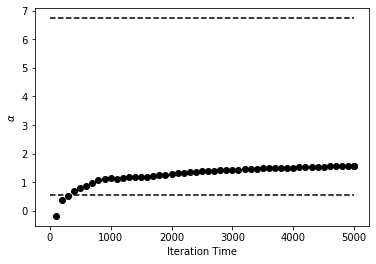

AttributeError: module 'matplotlib.pyplot' has no attribute 'showw'

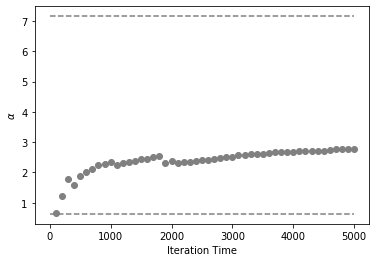

In [25]:
if __name__=="__main__":
    main()